In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

In [2]:
from pathlib import Path
import sys

current_dir = Path().absolute()
if str(current_dir.parent/'src') not in sys.path:
    sys.path.append(str(current_dir.parent/'src'))

from dataloaders import *
from arguments import *
from model import *
from train import *
from evaluate import *

import logging
import random
from tqdm import tqdm

import os
import datetime
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn

from transformers import CLIPModel, CLIPImageProcessor, CLIPTokenizerFast, CLIPProcessor

import warnings
warnings.filterwarnings("ignore")


#### Arguments

In [121]:
parser = get_args_parser()
args = parser.parse_args([])

# Change args here:
args.batch_size = 16


if 'clip' in args.pretrained_model_name:
    args.model_type = 'clip'
else:
    raise NotImplementedError(f'Unsupported model_type for {args.pretrained_model_name}')

if args.evaluation_metric=='f_beta':
    args.evaluation_metric = f'f_beta(beta={args.fbeta})'

print('Arguments:')
print('\n'.join(f'- {k}: {v}' for k, v in vars(args).items()))


Arguments:
- batch_size: 16
- n_epochs: 100
- lr: 0.0005
- weight_decay: 0.01
- beta1: 0.9
- beta2: 0.999
- adam_epsilon: 1e-08
- inference: False
- no_cuda: False
- seed: 1
- load_model_id: None
- fbeta: 0.5
- num_workers: 1
- evaluation_metric: precision
- inference_similarity_threshold: 0.86
- n_pairs_train: 10000
- n_pairs_val: 2500
- n_pairs_test: 2500
- positive_percentage_train: 0.5
- positive_percentage_val: 0.5
- positive_percentage_test: 0.5
- pretrained_model_name: openai/clip-vit-base-patch32
- margin: 1.0
- model_type: clip


#### Device: CPU or CUDA

In [122]:
# Device
device = torch.device('cuda:0' if not args.no_cuda and torch.cuda.is_available() else 'cpu')
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    logging.info(f"\nDevice: \n- {torch.cuda.get_device_name()}")
    torch.cuda.manual_seed(args.seed)
else:
    logging.info(f"\nDevice: {'CPU'}")

#### Project Directories

In [13]:
# Dirs
working_dir = current_dir.parent
data_dir = working_dir.joinpath('data', 'dataset')

text_data_filepath = data_dir.joinpath('data.txt')
thumbnail_data_dir = data_dir.joinpath('images')


model_dir_prefix = "Model_"
experiments_dir = working_dir/'experiments'/args.pretrained_model_name.replace('/','_')

### Data

The data consists of ads. Each ad is represented by :
1) a Thumbnail (a coloured image)
2) a Title (a text document)
3) a *cluster_id* (the cluster in which it belongs)


In [666]:
# Reset seed always before functions that apply data splitting, to ensure always creating the same data splits
reset_seeds(args.seed)


datasets_combined = get_datasets_combined(args, text_data_filepath, thumbnail_data_dir)

train_dataset_combined, val_dataset_combined, test_dataset_combined = datasets_combined

print(f'Total data samples: {len(train_dataset_combined.dataset)}')

print(f'Train: {len(train_dataset_combined)} - Val: {len(val_dataset_combined)} - Test: {len(test_dataset_combined)}')



Total data samples: 9525
Train: 5939 - Val: 1617 - Test: 1977


### Ad Example


 -Ad Title:
    "Heres the app you need to learn a new language -- try it now for free!"

- Ad Thumbnail:


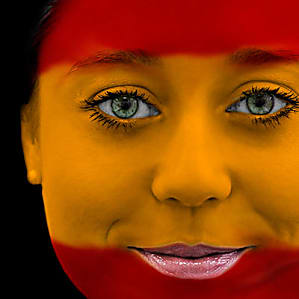

Belongs to cluster: 1


In [310]:
(text, image), cluster_id = train_dataset_combined[0]

print(" -Ad Title:")
print(f'    "{text}"')
print()

print("- Ad Thumbnail:")
display(transforms.functional.to_pil_image(image))

print(f"Belongs to cluster: {cluster_id}")


### Sample distribution along clusters

Each cluster represents an average of around 8.6 ± 7.3 samples.


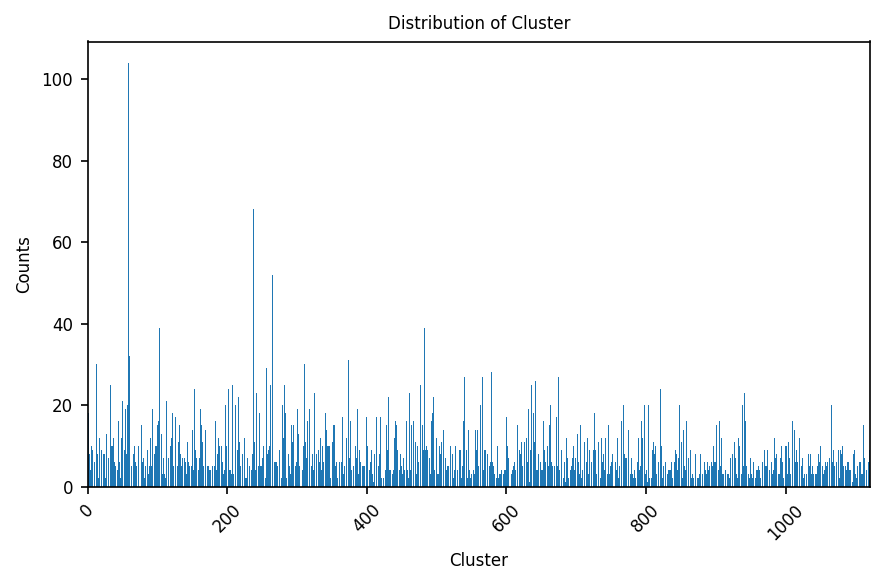

In [118]:
import matplotlib.pyplot as plt
from collections import Counter


plt.rcParams.update({'font.size': 10, 'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8})

# Count occurrences of each category
all_cluster_ids = [train_dataset_combined.dataset.get_label_by_idx(idx) for idx in range(len(train_dataset_combined.dataset))]
category_counts = Counter(all_cluster_ids)


mean_value = np.mean(counts)
std_value = np.std(counts)


print(f"Each cluster represents an average of around {mean_value:.1f} ± {std_value:.1f} samples.")


# Extract categories and counts
labels, counts = zip(*category_counts.items())

# Plotting the bar chart
plt.figure(figsize=(6, 4), dpi=150)
plt.bar(labels, counts, linewidth=2.5)

plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.title('Distribution of Cluster', fontsize=8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(0, max(labels))
# plt.ylim(0, max(counts) + 1)
plt.show()




<u>**Goal**</u>: Given pairs of ads, detemine whether they are simialar or not (deduplication task).

While a classification algorithm might seem suitable for this, the challenge arises from the vast diversity in the dataset. With:
1) over 1000 distinct clusters/categories and
2) only a few samples within each category

it becomes highly unlikely for the algorithm to establish a comprehensive representation for every individual category.


<u>**Solution**</u>: Create a dataset with each data sample corresponding to an Ad Pair.

### Ad Pair Dataset

For each data split separately (i.e. train, val, test), we take all the possible pair combinations of ads (within the same split) and create a new dataset per split named AdPairDataset. Each sample in this dataset is composed of:
 
1) a <u>pair of ads</u> $P$, i.e. means a pair $P$ of Text-Image pairs $P = (P_1,P_2)$ so that $P1= (Text_1, Image_1)$ and $P2= (Text_2, Image_2)$
2) a <u>binary label</u>, $1$ if $P1, P2$ are similar or $0$ if $P1, P2$ are dissimilar ($P1, P2$ are similar if they belong to the same cluster)


Note: Generating all possitble pair combinations yields a huge number of pairs and our computational power is limited. Moreover, obviously a very small percentage of similar pairs is generated compared to the dissimilar ones. Therefore, we generate all the possible pairs and sample in total `args.n_pairs_train`, `args.n_pairs_val`, `args.n_pairs_test` respectively, with `args.positive_percentage_train`, `args.positive_percentage_val` and `args.positive_percentage_test` determining the class distribution of each split correspondingly.


In [123]:
# Reset seed always before functions that apply data splitting, to ensure always creating the same data splits
reset_seeds(args.seed)


# Pair Dataloaders
pair_loaders = get_pair_dataloaders_combined(args, text_data_filepath, thumbnail_data_dir)
pair_train_loader, pair_val_loader, pair_test_loader = pair_loaders



In [722]:
train_pair_ad_dataset_labels = torch.tensor([pair_train_loader.dataset.dataset.get_label_by_idx(idx)
                                             for idx in range(len(pair_train_loader.dataset.dataset))])

val_pair_ad_dataset_labels = torch.tensor([pair_val_loader.dataset.dataset.get_label_by_idx(idx)
                                             for idx in range(len(pair_val_loader.dataset.dataset))])

test_pair_ad_dataset_labels = torch.tensor([pair_test_loader.dataset.dataset.get_label_by_idx(idx)
                                             for idx in range(len(pair_test_loader.dataset.dataset))])
print("Train Ad Pair Dataset (before sampling):")
print(f"- Positive Ad Pairs: {(train_pair_ad_dataset_labels==1).sum():,}")
print(f"- Negative Ad Pairs: {(train_pair_ad_dataset_labels==0).sum():,}")
print('\n')


print("Validation Ad Pair Dataset (before sampling):")
print(f"- Positive Ad Pairs: {(val_pair_ad_dataset_labels==1).sum():,}")
print(f"- Negative Ad Pairs: {(val_pair_ad_dataset_labels==0).sum():,}")
print('\n')

print("Test Ad Pair Dataset (before sampling):")
print(f"- Positive Ad Pairs: {(test_pair_ad_dataset_labels==1).sum():,}")
print(f"- Negative Ad Pairs: {(test_pair_ad_dataset_labels==0).sum():,}")


Train Ad Pair Dataset (before sampling):
- Positive Ad Pairs: 62,141
- Negative Ad Pairs: 35,209,580


Validation Ad Pair Dataset (before sampling):
- Positive Ad Pairs: 3,545
- Negative Ad Pairs: 2,611,144


Test Ad Pair Dataset (before sampling):
- Positive Ad Pairs: 4,901
- Negative Ad Pairs: 3,903,628


### Pairs of Similar or Dissimilar Ads

#### Pair of Similar Ads

- Ad #1 Title :
    "You're Going to Love the New Senior Living Accommodations in ${city:capitalized}$"

- Ad #1 Thumbnail:


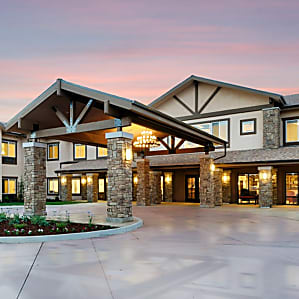



- Ad #2 Title:
    "Sensational Luxury Senior Apartments Available in ${city:capitalized}$"

- Ad #2 Thumbnail:


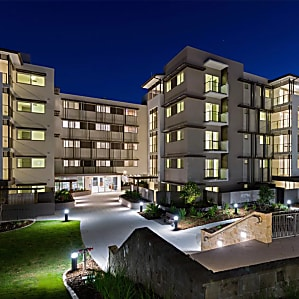

In [301]:
while True:
    i = random.randint(0, len(pair_train_loader.dataset)-1)
    data, label = pair_train_loader.dataset[i]
    if label==1:
        break


(text1, image1), (text2, image2) = data

print("- Ad #1 Title :")
print(f'    "{text1}"')
print()

print("- Ad #1 Thumbnail:")
display(transforms.functional.to_pil_image(image1))
print('\n')


print("- Ad #2 Title:")
print(f'    "{text2}"')
print()

print("- Ad #2 Thumbnail:")
display(transforms.functional.to_pil_image(image2))




#### Pair of Dissimilar Ads

- Ad #1 Title :
    "12 Tips for an Elimination Diet for Eczema"

- Ad #1 Thumbnail:


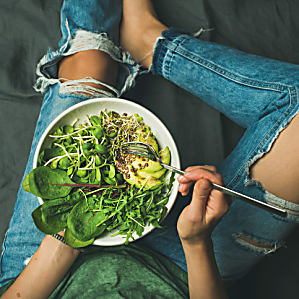



- Ad #2 Title:
    "Science Can't Expalin This 25 Amazing Mysteries"

- Ad #2 Thumbnail:


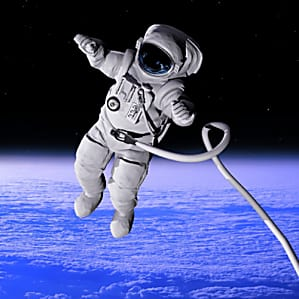

In [302]:
while True:
    i = random.randint(0, len(pair_train_loader.dataset)-1)
    data, label = pair_train_loader.dataset[i]
    if label==0:
        break


(text1, image1), (text2, image2) = data

print("- Ad #1 Title :")
print(f'    "{text1}"')
print()

print("- Ad #1 Thumbnail:")
display(transforms.functional.to_pil_image(image1))
print('\n')


print("- Ad #2 Title:")
print(f'    "{text2}"')
print()

print("- Ad #2 Thumbnail:")
display(transforms.functional.to_pil_image(image2))




### Architecture

We are employing a CLIP model for extracting multi-modal embedding vectors. More specifically we use a ViT-based pretrained version which can be found on Hugging Face as `openai/clip-vit-base-patch32`.

In [315]:
print(f"- Model: {args.model_type.upper()}")
print(f"- Pretrained Model Name: {args.pretrained_model_name})")


- Model: CLIP
- Pretrained Model Name: openai/clip-vit-base-patch32)


In [316]:
# Image Processor: 
# Preprocess the input image the way the pretrained model expects 
image_processor = CLIPImageProcessor.from_pretrained(args.pretrained_model_name)

# Modify 'do rescale' because our images are already scaled to [0,1]
image_processor_dict = image_processor.to_dict()
image_processor_dict['do_rescale'] = False
image_processor = CLIPImageProcessor(**image_processor_dict)


# CLIPTokenizerFast: 
# Preprocess/Tokenize the input document the way the pretrained model expects 
tokenizer = CLIPTokenizerFast.from_pretrained(args.pretrained_model_name)


# CLIPProcessor: 
# Combine the two processors into one
processor = CLIPProcessor(image_processor=image_processor, tokenizer=tokenizer)


# CLIPModel
clip_model = CLIPModel.from_pretrained(args.pretrained_model_name).to(device)

We initialise `CLIPModelModified` which is same as the `CLIPModel` but instead `forward()` only returns a `dict` with the image and text embeddings.

Then we initialise `MultiModalSiameseNetwork`, a Siamese network that:
1) takes two Text-Image pairs
2) passes them through a CLIP model with shared weights and configuration
3) generates a 512-dim embedding vector per modality per pair (4 in total)
4) fuses the Text-Image embedding vectors into a combined one for each pair (2 1024-dim fused embedding vectors)
5) passes these through an additional Residual Layer (with an FC) for final projection

Note: The idea is to freeze CLIP and fine-tune the additional layer placed on top, given that pretrained CLIP can be used as a backbone and compute powerful representations for both Text and Images in a shared latent space.

In [317]:
# Same as the CLIPModel but instead forward() only returns the image and text embeddings
multimodal_network = CLIPModelModified(clip_model).to(device)

# Siamese Netework
model = MultiModalSiameseNetwork(multimodal_network).to(device)

### Trainging Objective & Loss Function

The training objective is the minimization of the ***Contrastive Loss*** between two embedding vectors:

$$\mathcal{L}_{\text{contrastive}} = \frac{1}{2}\left[(1-y)\cdot D_W^2(\vec{x_1}, \vec{x_2}) + y \cdot \max\left\{ 0, m-D_W(\vec{x_1}, \vec{x_2})\right\}^2\right]$$

The minimization of ***Contrastive Loss*** encourages similar instances to be closer and dissimilar instances to be farther apart in an embedding space.

- $y$: The binary variable corresponding to the sample's label possitive (1) or negative (0)
- $\vec{x_1}, \vec{x_2}$: The normalized embedding vectors computed by our Siamese Network corresponding to the two Text-Image pairs
- $D_W(\cdot,\cdot)$: The distance between $\vec{x_1}, \vec{x_2}$. We are using the Euclidean distance.

In [329]:
loss_fn = ContrastiveLoss(margin=args.margin)

We employ an `AdamW` optimizer. We freeze all CLIP parameters and only optimize the trainable parameters corresponding to the additional linear head. 

In [319]:
# Returns only the final layers parameters
param_groups = get_param_groups_for_finetuning(model, args.model_type)
optimizer = optim.AdamW(param_groups, lr=args.lr, betas=(args.beta1, args.beta2), weight_decay=args.weight_decay, eps=args.adam_epsilon)

# Trainable parameters
trainable_params = sum(p.numel() for p in optimizer.param_groups[0]['params'] if p.requires_grad)
print(f'\nTrainable parameters: {trainable_params:,}\n')


Trainable parameters: 1,049,600



For more details regarding the implementation of the training loop you can a check `main.py` located in the `/src` directory. Here we provide the output of a full training run using the optimal hyperparameters that were found to be the same as the ones suggested in the original CLIP paper  <a href="https://arxiv.org/pdf/2103.00020.pdf">[1]</a>. We do this by running the following command from the notebook:




```bash
!python3 ../src/main.py --batch_size 64 --n_epochs 10 --n_pairs_train 10000 --n_pairs_val 2500 --n_pairs_test 2500 --evaluation_metric 'f1_score' --num_workers 2 --lr 9e-5 --weight_decay 0.2 --beta1 0.9 --beta2 0.98 --adam_epsilon 1e-6 --margin 1.0 --fbeta 0.75
```


In [695]:
# !python3 ../src/main.py --batch_size 64 --n_epochs 10 --n_pairs_train 10000 --n_pairs_val 2500 --n_pairs_test 2500 --evaluation_metric 'f1_score' --num_workers 2 --lr 9e-5 --weight_decay 0.2 --beta1 0.9 --beta2 0.98 --adam_epsilon 1e-6 --margin 1.0 --fbeta 0.75

Model_ID: 4

2023-11-26 22:24:00.718815

Device: 
- Tesla V100-SXM2-16GB

Arguments:
- batch_size: 64
- n_epochs: 5
- lr: 0.0005
- weight_decay: 0.2
- beta1: 0.9
- beta2: 0.98
- adam_epsilon: 1e-06
- inference: False
- no_cuda: False
- seed: 1
- load_model_id: None
- fbeta: 0.75
- num_workers: 2
- evaluation_metric: f1_score
- inference_similarity_threshold: 0.86
- n_pairs_train: 10000
- n_pairs_val: 2500
- n_pairs_test: 2500
- positive_percentage_train: 0.5
- positive_percentage_val: 0.5
- positive_percentage_test: 0.5
- pretrained_model_name: openai/clip-vit-base-patch32
- margin: 1.0
- model_type: clip
- cuda: True


Loading Dataset...
Train: 10000 - Val: 2500 - Test: 2500

Positive/Negative Ratio:

Train: 50/50- Val: 50/50- Test: 50/50

Trainable parameters: 1,049,600

Fine-tune model on target task for 5 epochs:

Epoch [1/5]: Train Loss: 0.0825 | Validation Loss: 0.0618
             Validation Metrics (threshold=0.81): 
             Accuracy: 0.9636 | Precision: 0.9461 | Recall: 0

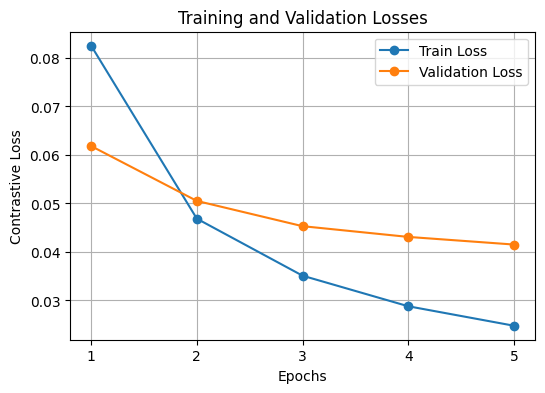

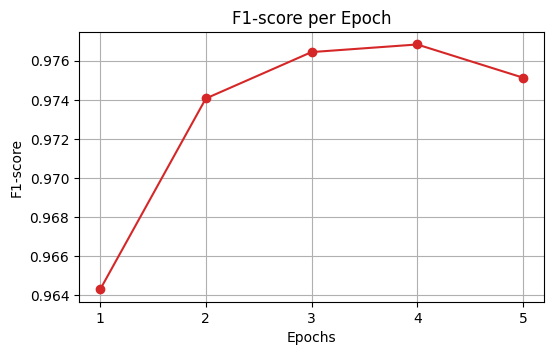

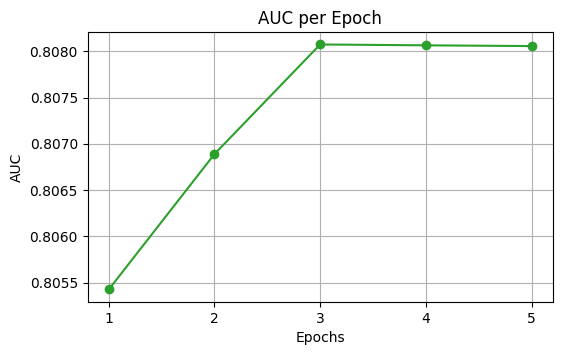

In [765]:
import csv
import matplotlib


with open(experiments_dir/(model_dir_prefix + str(args.load_model_id))/'train_losses.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        train_losses = [float(x) for x in row]

with open(experiments_dir/(model_dir_prefix + str(args.load_model_id))/'val_losses.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        val_losses = [float(x) for x in row]



with open(experiments_dir/(model_dir_prefix + str(args.load_model_id))/'val_metrics.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        val_metrics = [float(x) for x in row]

with open(experiments_dir/(model_dir_prefix + str(args.load_model_id))/'val_aucs.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        val_aucs = [float(x) for x in row]
        



default_colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

epochs = range(1, len(train_losses) + 1)

# Plot Loss
fig = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Contrastive Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(train_losses) + 1))
plt.show()


# Plot F1
plt.figure(figsize=(6, 3.5))
plt.plot(epochs, val_metrics, label='Validation F1-score', marker='o', color=default_colors[3])
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score per Epoch')
plt.grid(True)
plt.xticks(range(1, len(val_metrics) + 1))
plt.show()



# Plot AUC
plt.figure(figsize=(6, 3.5))
plt.plot(epochs, val_aucs, label='Validation AUC', marker='o', color=default_colors[2])
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('AUC per Epoch')
plt.grid(True)
plt.xticks(range(1, len(val_aucs) + 1))
plt.show()




Although the Validation Loss appeared to continue decreasing, we utilized the AUC metric for model selection. Specifically, we opted for the model state achieved during Epoch 3, where the AUC reached its peak value.

#### Load fine-tuned model

In [345]:
# Load Model
args.load_model_id = 4

load_dir = os.path.join(experiments_dir, model_dir_prefix + str(args.load_model_id))
load_path = os.path.join(load_dir, f"checkpoint_{args.load_model_id}.pt")
logging.info(f'\nLoading {model_dir_prefix}{args.load_model_id} from "{load_path}"\n')
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)


We decided to train on a completely balanced set, in order for the model to learn both representations equally (in either case Contrastive Loss's nature makes it good at handling imbalances). But for the case of Validation we should evaluate the model to a dataset that resembles the "world's" data distribution.



Here we compute all the similarities over Validation sets consisting of 5000 ad pairs, but each time we vary the Positive/Negative Ratio in a range $[10\%, 50\%]$ wrt the positives, getting closer and closer to the natural data generating process/distribution. 

Note: Our dataset has showed that $\approx 99.9\%$ of the pairs are dissimilar (negatives). 

In [407]:
from evaluate import *

similarities_dict = {}
labels_dict = {}

args.batch_size = 32
args.n_pairs_val = 5000
args.positive_percentage_val = 0.5

percentages = [0.1, 0.2, 0.3, 0.4, 0.5]

for percentage in percentages:
    
    percentage = round(percentage, 1)
    
    print(f"For {int(percentage*100)}/{int(100-percentage*100)}:\n")

    args.positive_percentage_val = percentage
    
    # Reset seed always before functions that apply data splitting, to ensure always creating the same data splits
    reset_seeds(args.seed)

    # Pair Dataloaders
    _, pair_val_loader, _ = get_pair_dataloaders_combined(args, text_data_filepath, thumbnail_data_dir)
    
    
    sims, labs = compute_similarities(pair_val_loader, model, processor, device)
    
    similarities_dict[percentage] = sims
    labels_dict[percentage] = labs
    

For 50/50:



100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [04:47<00:00,  2.07s/it]


For 40/60:



100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [05:22<00:00,  2.10s/it]


For 30/70:



100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [05:29<00:00,  2.10s/it]


For 20/80:



100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [05:27<00:00,  2.09s/it]


For 10/90:



100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [05:32<00:00,  2.12s/it]


In [497]:
optimization_metric = 'f1_score'
# optimization_metric = 'f_beta(beta=0.75)'

fbeta = 0.75
print(f"Optimizing with respect to {optimization_metric}\n\n")


thresholds = torch.arange(-1, 1, 0.001)

f1_scores = []
precisions = []
recalls = []
f_beta_scores = []

optimal_thresholds = []
optimal_eval_metrics = []

for percentage in percentages:
    
    percentage = round(percentage, 1)
    
    metrics, optimal_threshold, auc = optimal_metric_score_with_threshold(
                                                similarities=torch.tensor(similarities_dict[percentage]),
                                                y_true=torch.tensor(labels_dict[percentage]),
                                                thresholds=thresholds,
                                                optimization_metric=optimization_metric,
                                                return_auc=True,
                                                fbeta=fbeta)
    
    
    optimal_thresholds.append(optimal_threshold)
    optimal_eval_metrics.append(metrics[optimization_metric])
    
    f1_scores.append(metrics['f1_score'])
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f_beta_scores.append(metrics['f_beta(beta=0.75)'])
    
    
    print(f"For {int(round(percentage,1)*100)}/{int(100-round(percentage,1)*100)}:\n")
    
    print(f"- Optimal Threshold: {optimal_threshold:.3f}")
    print(f"- AUC: {auc:.4f}")
    print(f"- "+ '\n- '.join([f'{metric_str.capitalize()}: {metric_score:.4f}' for metric_str, metric_score in metrics.items()]) )
    print('\n')
    


Optimizing with respect to f1_score


For 10/90:

- Optimal Threshold: 0.905
- AUC: 0.7835
- Accuracy: 0.9864
- Precision: 0.9390
- Recall: 0.9240
- F1_score: 0.9315
- F_beta(beta=0.75): 0.9336


For 20/80:

- Optimal Threshold: 0.884
- AUC: 0.8016
- Accuracy: 0.9812
- Precision: 0.9530
- Recall: 0.9530
- F1_score: 0.9530
- F_beta(beta=0.75): 0.9530


For 30/70:

- Optimal Threshold: 0.884
- AUC: 0.7921
- Accuracy: 0.9774
- Precision: 0.9727
- Recall: 0.9513
- F1_score: 0.9619
- F_beta(beta=0.75): 0.9649


For 40/60:

- Optimal Threshold: 0.839
- AUC: 0.7949
- Accuracy: 0.9752
- Precision: 0.9574
- Recall: 0.9803
- F1_score: 0.9687
- F_beta(beta=0.75): 0.9655


For 50/50:

- Optimal Threshold: 0.839
- AUC: 0.7956
- Accuracy: 0.9756
- Precision: 0.9643
- Recall: 0.9803
- F1_score: 0.9722
- F_beta(beta=0.75): 0.9700





By **decreasing** the <u>percentage of possitves</u> we move closer to the actual data generating process/distribution. 

What we notice is that this decrease leads to **increase** in the <u>optimal threshold</u>. This makes total sense as increasing this threshold means "being more cautious" when predicting something as possitive (and since the prior distributions tell us that possitves are much fewer than the negatives, it makes sense to predict a pair as possitive less frequently).

<!-- Thus, when it comes to choosing the optimal decision -->



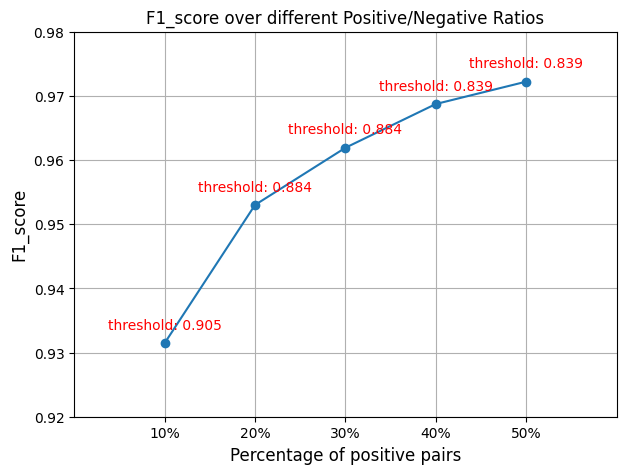

In [498]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()

x_values = [100*round(percentage,1) for percentage in percentages]

# Plot the data
plt.figure(figsize=(7, 5))
plt.plot(x_values, optimal_eval_metrics, marker='o', linestyle='-')

# Add text labels for optimal thresholds on each point
for i, txt in enumerate(optimal_thresholds):
    plt.annotate(f'threshold: {round(txt, 3)}', (x_values[i], optimal_eval_metrics[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

# Set plot labels and title
plt.xlabel('Percentage of positive pairs', fontsize=12)
plt.ylabel(f'{optimization_metric.capitalize()}', fontsize=12)
plt.title(f'{optimization_metric.capitalize()} over different Positive/Negative Ratios')

plt.xticks(x_values, [f'{x:.0f}%' for x in x_values])

plt.xlim(0, 60)  # Adjust the x-axis limits
plt.ylim(0.92, 0.98)  # Adjust the y-axis limits


# Show plot
plt.grid(True)
plt.show()


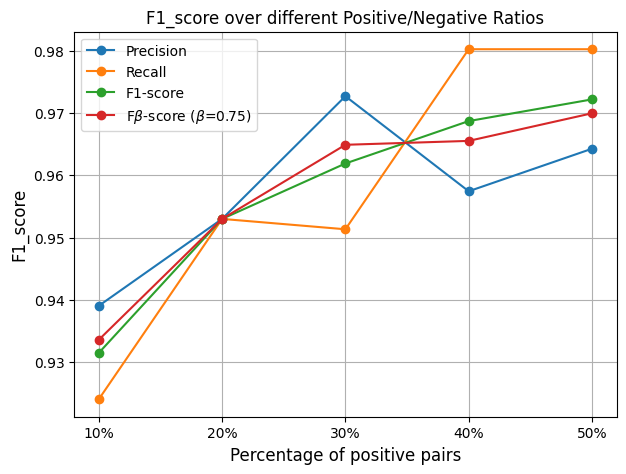

In [499]:
optimal_eval_metrics

import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
BETA_GREEK = r"$\beta$"
x_values = [100*round(percentage,1) for percentage in percentages]

# Plot the data
plt.figure(figsize=(7, 5))
plt.plot(x_values, precisions, marker='o', linestyle='-', label='Precision')
plt.plot(x_values, recalls, marker='o', linestyle='-', label='Recall')
plt.plot(x_values, f1_scores, marker='o', linestyle='-', label='F1-score')
plt.plot(x_values, f_beta_scores, marker='o', linestyle='-',  label=f'F{BETA_GREEK}-score ({BETA_GREEK}={fbeta})')



# Set plot labels and title
plt.xlabel('Percentage of positive pairs', fontsize=12)
plt.ylabel(f'{optimization_metric.capitalize()}', fontsize=12)
plt.title(f'{optimization_metric.capitalize()} over different Positive/Negative Ratios')

plt.xticks(x_values, [f'{x:.0f}%' for x in x_values])

# plt.xlim(0, 60)  # Adjust the x-axis limits
# plt.ylim(0.92, 0.98)  # Adjust the y-axis limits

plt.legend()

# Show plot
plt.grid(True)
plt.show()


In [573]:
precisions = []
recalls = []

for percentage in percentages:
    
    percentage = round(percentage, 1)

    metrics, _, auc = optimal_metric_score_with_threshold(
                                            similarities=torch.tensor(similarities_dict[percentage]),
                                            y_true=torch.tensor(labels_dict[percentage]),
                                            thresholds=torch.arange(-1, 1, 0.001),
                                            optimization_metric='f1_score',
                                            return_auc=True,
                                            fbeta=fbeta,
                                            return_metrics_per_threshold=True)
    
    

    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])


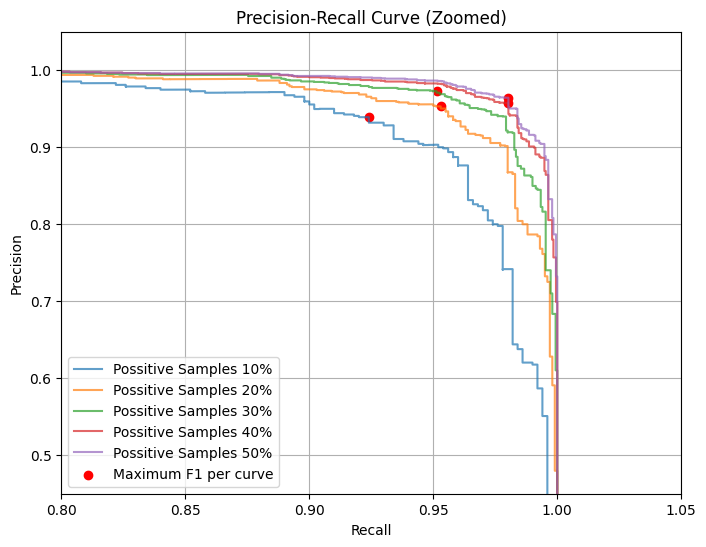

In [574]:
# Plot precision-recall curve

threshold_idxs = (torch.round(thresholds, decimals=3) == torch.round(torch.tensor(optimal_thresholds), decimals=3).unsqueeze(1)).max(dim=1).indices

plt.figure(figsize=(8, 6))
for i, (precision, recall) in enumerate(zip(precisions, recalls)):
    plt.step(recall, precision, alpha=0.7, where='post', label=f'Possitive Samples {int(100*percentages[i])}%')

optimal_recalls = [recalls[i][idx] for i, idx in enumerate(threshold_idxs)]
optimal_precisions = [precisions[i][idx] for i, idx in enumerate(threshold_idxs)]
plt.scatter(optimal_recalls, optimal_precisions, color='red', label='Maximum F1 per curve')
    
# plt.fill_between(recalls[0], precisions[0], alpha=0.5, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.45, 1.05])
plt.xlim([0.8, 1.05])
plt.title('Precision-Recall Curve (Zoomed)')
plt.grid()
plt.legend()
plt.show()



The precision-recall curve shows a great performance accross a very wide range of thresholds, with very little compromise of the one compared to the other.


In this project, the model selection is done using the AUC metric, which is a way to evaluate the overall performance of a model accross different thresholds.

The determination of the optimal decision threshold lacks a definitive answer. It depends to what one wants to achieve. A high AUC indicates the model's potential to perform effectively across a broad spectrum of precisions and recalls, potentially compromising one for the other, but to the least extent possible.


To determine the optimal threshold one needs to answer a few questions:

- How important false possitives are, which is pairs being mistakenly identified as duplicates
- How critical false negatives are, which is missing a pair of duplicates




In our scenario, determining the objective and extent of optimization for the deduplication algorithm remains uncertain. Hence, we chose to define the optimal threshold as the value maximizing the $F_1$ score of the validation set, representing the harmonic mean of Precision and Recall, thereby ensuring a balanced performance between the two metrics. Additionally, we provide the $F_\beta$ score, where $\beta=0.75$, emphasizing a slightly higher weight on Precision in positive predictions.

Our formulation and implementation offer flexibility for swift adjustments in the optimal decision threshold across diverse scenarios enhancing the algorithm's versatility.



Taking all the above into account, and all the validation results, the optimal threshold will be selected as the one that **maximizes the $F_1$-score**, when the **positive / negative ratio is $10\,\,/\,\, 90$**, which is closer to the true data distribution (as mentioned above $\approx 1 \,\,/\,\, 999$)

Therefore, the selected optimal threshold will be set at 0.905. This threshold will be evaluated on a completely unseen test set with a 10/90 ratio, (providing a better reflection of the true class distribution for performance assessment).



In [576]:
from evaluate import *

test_similarities_dict = {}
test_labels_dict = {}

args.batch_size = 32
args.n_pairs_test = 5000
args.positive_percentage_test = 0.1

# percentages = [0.1, 0.2, 0.3, 0.4, 0.5]

# for percentage in percentages:
    
# percentage = round(percentage, 1)

print(f"For {int(args.positive_percentage_test*100)}/{int(100-args.positive_percentage_test*100)}:\n")

# args.positive_percentage_val = percentage

# Reset seed always before functions that apply data splitting, to ensure always creating the same data splits
reset_seeds(args.seed)

# Pair Dataloaders
_, _, pair_test_loader = get_pair_dataloaders_combined(args, text_data_filepath, thumbnail_data_dir)


test_sims, test_labs = compute_similarities(pair_test_loader, model, processor, device)

test_similarities_dict[percentage] = test_sims
test_labels_dict[percentage] = test_labs


For 10/90:



100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [05:48<00:00,  2.22s/it]


For Test set with 5000 ad pairs and a 10/90 ratio, using a decision threshold of 0.905:

- AUC: 0.7831
- Accuracy: 0.9850
- Precision: 0.9418
- Recall: 0.9060
- F1_score: 0.9235
- F_beta(beta=0.75): 0.9286




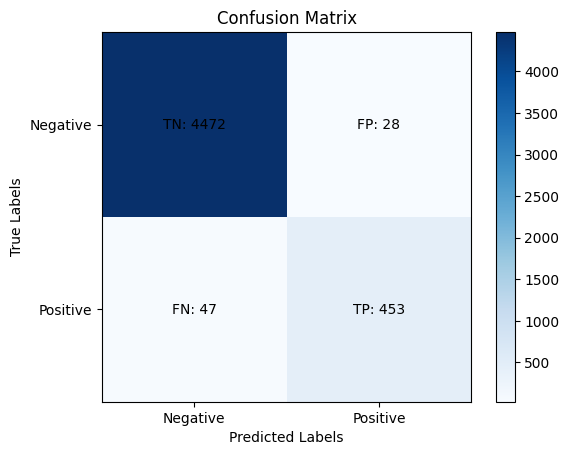

In [660]:
inference_similarity_threshold = 0.905

test_optimal_metrics, test_optimal_threshold, test_auc = optimal_metric_score_with_threshold(
                                                                        similarities=torch.tensor(test_sims),
                                                                        y_true=torch.tensor(test_labs),
                                                                        thresholds=thresholds,
                                                                        return_auc=True,
                                                                        optimization_metric='f1_score',
                                                                        fbeta=0.75)


test_metrics, _ = optimal_metric_score_with_threshold(similarities=torch.tensor(test_sims),
                                                        y_true=torch.tensor(test_labs),
                                                        thresholds=torch.tensor([inference_similarity_threshold]),
                                                        return_auc=False,
                                                        optimization_metric='f1_score',
                                                        fbeta=0.75)


print(f"For Test set with {args.n_pairs_test} ad pairs and a " +
      f"{int(round(args.positive_percentage_test,1)*100)}/{int(100-round(args.positive_percentage_test,1)*100)} "+
      f"ratio, " +
      f"using a decision threshold of {inference_similarity_threshold:.3f}:\n")
    
print(f"- AUC: {test_auc:.4f}")
print(f"- "+ '\n- '.join([f'{metric_str.capitalize()}: {metric_score:.4f}' for metric_str, metric_score in test_metrics.items()]) )
print('\n')


from evaluate import *

tp, fp, tn, fn = get_confusion_matrix_by_thresholds(similarities=torch.tensor(test_sims),
                                                    y_true=torch.tensor(test_labs),
                                                    thresholds=torch.tensor([inference_similarity_threshold]))

tn = tn.item()
fp = fp.item()
fn = fn.item()
tp = tp.item()

confusion_matrix = [[tn, fp], [fn, tp]]
confusion_matrix_labels = [['TN', 'FP'], ['FN', 'TP']]

# Plotting the confusion matrix
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Annotate each cell with respective counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{confusion_matrix_labels[i][j]}: {confusion_matrix[i][j]}', horizontalalignment='center', verticalalignment='center', color='black')


plt.show()


To run inference similarly we could run:

```bash
!python3 ../src/main.py --inference --load_model_id 4 --batch_size 32 --inference_similarity_threshold 0.905 --n_pairs_test 5000 --positive_percentage_test 0.1 --fbeta 0.75 --num_workers 2 --seed 1
```

In [664]:
!python ../src/main.py --inference --load_model_id 4 --batch_size 32 --inference_similarity_threshold 0.905 --n_pairs_test 5000 --positive_percentage_test 0.1 --fbeta 0.75 --num_workers 2 --seed 1

## Bibliography

<a href="https://arxiv.org/pdf/2103.00020.pdf">[1]</a> Radford A, Kim JW, Hallacy C, Ramesh A, Goh G, Agarwal S, Sastry G, Askell A, Mishkin P, Clark J, Krueger G. Learning transferable visual models from natural language supervision. InInternational conference on machine learning 2021 Jul 1 (pp. 8748-8763). PMLR.
